**Dual LSTM Encoder for Dialog Response Generation**

http://www.wildml.com/2016/07/deep-learning-for-chatbots-2-retrieval-based-model-tensorflow/

https://github.com/dennybritz/chatbot-retrieval

https://github.com/rkadlec/ubuntu-ranking-dataset-creator

https://arxiv.org/abs/1506.08909

In [1]:
import tensorflow as tf
tf.VERSION

'1.2.0'

### 1. Download Dataset

In [2]:
# https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(share_id, filename):
    GOOGLE_DRIVE_URL = "https://drive.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(GOOGLE_DRIVE_URL, params={'id': share_id}, stream=True)
    
    token = None
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            token = value
            break

    if not token:
        raise Exception('Token not found')
        
    params = {'id': share_id, 'confirm': token}
    response = session.get(GOOGLE_DRIVE_URL, params=params, stream=True)

    with open(filename, 'wb') as f:
        for chunk in response.iter_content(32768):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [3]:
import os
import tarfile
import shutil

HOME_DIR = 'ubuntu'
DATA_DIR = os.path.join(HOME_DIR, 'data')
DATASET_FILENAME = 'udc.tar.gz'
DATASET_PACKAGE = os.path.join(DATA_DIR, DATASET_FILENAME)
SHARE_ID = '0B_bZck-ksdkpVEtVc1R6Y01HMWM'

TRAIN_CSV = os.path.join(DATA_DIR, 'train.csv')
VALID_CSV = os.path.join(DATA_DIR, 'valid.csv')
TEST_CSV = os.path.join(DATA_DIR, 'test.csv')

if not os.path.isdir(DATA_DIR):
    os.makedirs(DATA_DIR)

train_missing = not os.path.isfile(TRAIN_CSV)
valid_missing = not os.path.isfile(VALID_CSV)
test_missing = not os.path.isfile(TEST_CSV)

missing = train_missing or valid_missing or test_missing

if missing and not os.path.isfile(DATASET_PACKAGE):
    print('Downloading {}...'.format(DATASET_FILENAME))
    download_file_from_google_drive(SHARE_ID, DATASET_PACKAGE)
    print('Done!')

def extract(tar, filename, dst_path):
    print('Extracting', filename)
    dst_file = os.path.join(dst_path, os.path.basename(filename))
    with open(dst_file, 'wb') as fout:
        fin = tar.extractfile(filename)
        shutil.copyfileobj(fin, fout)

if missing:
    with tarfile.open(DATASET_PACKAGE, mode='r:gz') as t:
        if train_missing:
            extract(t, './data/train.csv', DATA_DIR)
        if valid_missing:
            extract(t, './data/valid.csv', DATA_DIR)
        if test_missing:
            extract(t, './data/test.csv', DATA_DIR)

os.listdir(DATA_DIR)

Done!
Extracting ./data/train.csv
Extracting ./data/valid.csv
Extracting ./data/test.csv


['udc.tar.gz', 'train.csv', 'valid.csv', 'test.csv']

In [4]:
def show(file, lines=3):
    with open(file, 'r') as f:
        for _ in range(lines):
            print(next(f).strip())
            print()

print('Train samples...\n')
show(TRAIN_CSV)
print('...\n')
print('Validation samples...\n')
show(VALID_CSV)
print('...\n')
print('Test samples...\n')
show(TEST_CSV)

Train samples...

Context,Utterance,Label

"i think we could import the old comment via rsync , but from there we need to go via email . i think it be easier than cach the status on each bug and than import bite here and there __eou__ __eot__ it would be veri easi to keep a hash db of message-id __eou__ sound good __eou__ __eot__ ok __eou__ perhap we can ship an ad-hoc apt_preferec __eou__ __eot__ version ? __eou__ __eot__ thank __eou__ __eot__ not yet __eou__ it be cover by your insur ? __eou__ __eot__ yes __eou__ but it 's realli not the right time : / __eou__ with a chang hous upcom in 3 week __eou__ __eot__ you will be move into your hous soon ? __eou__ post a messag recent which explain what to do if the autoconfigur doe not do what you expect __eou__ __eot__ how urgent be # 896 ? __eou__ __eot__ not particular urgent , but a polici violat __eou__ __eot__ i agre that we should kill the -novtswitch __eou__ __eot__ ok __eou__ __eot__ would you consid a packag split a featur ? __eou_

### 2. Create Vocabulary

In [5]:
help(tf.contrib.learn.preprocessing.VocabularyProcessor)

Help on class VocabularyProcessor in module tensorflow.contrib.learn.python.learn.preprocessing.text:

class VocabularyProcessor(builtins.object)
 |  Maps documents to sequences of word ids.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, max_document_length, min_frequency=0, vocabulary=None, tokenizer_fn=None)
 |      Initializes a VocabularyProcessor instance.
 |      
 |      Args:
 |        max_document_length: Maximum length of documents.
 |          if documents are longer, they will be trimmed, if shorter - padded.
 |        min_frequency: Minimum frequency of words in the vocabulary.
 |        vocabulary: CategoricalVocabulary object.
 |      
 |      Attributes:
 |        vocabulary_: CategoricalVocabulary object.
 |  
 |  fit(self, raw_documents, unused_y=None)
 |      Learn a vocabulary dictionary of all tokens in the raw documents.
 |      
 |      Args:
 |        raw_documents: An iterable which yield either str or unicode.
 |        unused_y: to match fit format si

**Exploration**

Parameters:

* `max_document_length`
* `min_frequency`

In [6]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

plt.rc('figure', figsize=(16.0, 8.0))

In [7]:
%%time
train_df = pd.read_csv(TRAIN_CSV)
train_df.Label = train_df.Label.astype('category')

CPU times: user 6.06 s, sys: 206 ms, total: 6.26 s
Wall time: 6.28 s


In [8]:
%%time
train_context_len = train_df.Context.str.split().str.len()
context_stats = train_context_len.describe()
print(context_stats)

count    1000000.000000
mean          86.339190
std           74.929711
min            5.000000
25%           37.000000
50%           63.000000
75%          108.000000
max         1879.000000
Name: Context, dtype: float64
CPU times: user 15 s, sys: 1.33 s, total: 16.3 s
Wall time: 16.6 s


In [9]:
import math

Q1 = context_stats['25%']
Q3 = context_stats['75%']

max_len = math.ceil((Q3 + 1.5 * (Q3 - Q1)) / 10) * 10

print(max_len)

220


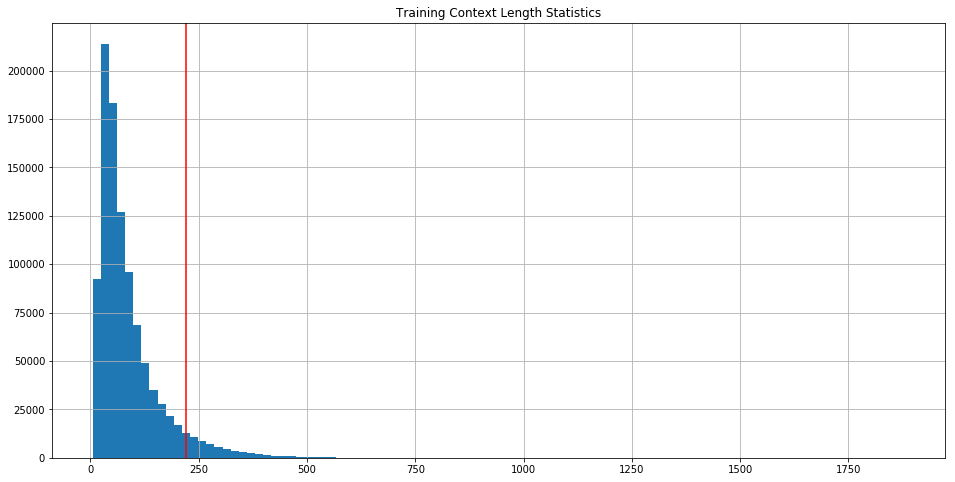

In [10]:
train_context_len.hist(bins=100)
plt.axvline(max_len, color='r')
plt.title('Training Context Length Statistics')

In [11]:
%%time
train_utterance_len = train_df.Utterance.str.split().str.len()
print(train_utterance_len.describe())

count    1000000.000000
mean          17.246391
std           16.422901
min            1.000000
25%            7.000000
50%           13.000000
75%           22.000000
max          653.000000
Name: Utterance, dtype: float64
CPU times: user 4.12 s, sys: 281 ms, total: 4.4 s
Wall time: 4.38 s


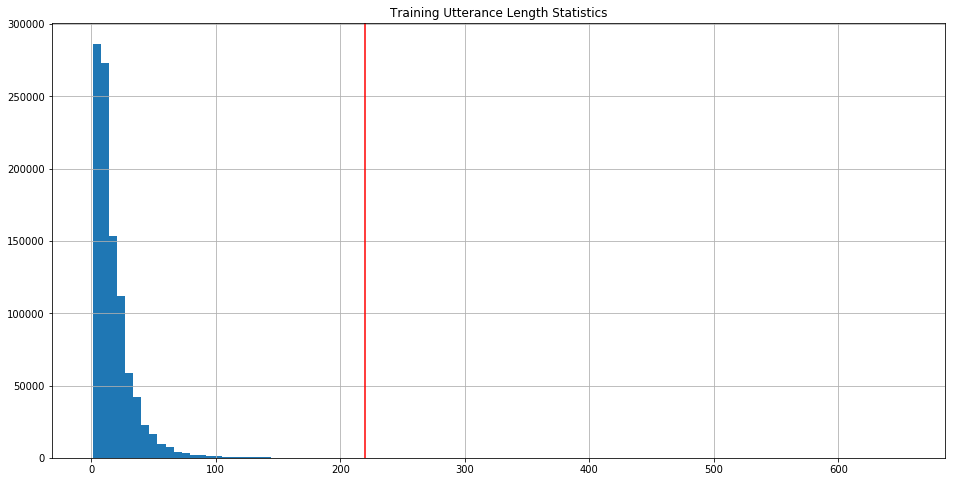

In [12]:
train_utterance_len.hist(bins=100)
plt.axvline(max_len, color='r')
plt.title('Training Utterance Length Statistics')

In [13]:
del train_context_len
del train_utterance_len

In [14]:
%%time

import collections

token_freq = collections.Counter()
for _, (c, u, _) in train_df.iterrows():
    context_tokens = c.split()
    utterance_tokens = u.split()
    token_freq.update(context_tokens)
    token_freq.update(utterance_tokens)

print(len(token_freq))
print()
for token, freq in token_freq.most_common(10):
    print('{:,d}\t{}'.format(freq, token))

744894

7,588,913	__eou__
3,954,151	__eot__
3,295,688	i
2,751,981	the
2,708,162	,
2,578,439	be
2,372,587	?
2,317,280	to
2,177,149	it
1,812,457	.
CPU times: user 2min 6s, sys: 0 ns, total: 2min 6s
Wall time: 2min 6s


In [15]:
token_5 = list((token, freq) for token, freq in token_freq.items() if freq >= 5)
len(token_5)

107978

In [16]:
token_5_df = pd.Series(data=list(freq for _, freq in token_5))
token_5_stats = token_5_df.describe()
print(token_5_stats)

count    1.079780e+05
mean     9.504408e+02
std      3.711082e+04
min      5.000000e+00
25%      6.000000e+00
50%      1.100000e+01
75%      2.800000e+01
max      7.588913e+06
dtype: float64


In [17]:
Q1 = token_5_stats['25%']
Q3 = token_5_stats['75%']

high_freq = Q3 + 1.5 * (Q3 - Q1)

high_freq

61.0

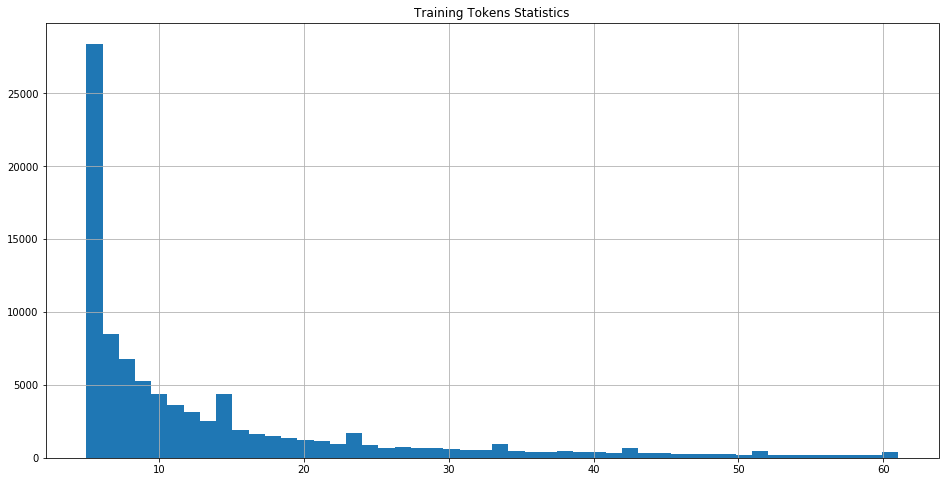

In [18]:
token_5_df[token_5_df <= high_freq].hist(bins=50)
plt.title('Training Tokens Statistics')

In [19]:
del train_df
del token_freq

**Vocabulary**

In [20]:
import csv

def csv_iterator(filename, cols=[]):
    with open(filename, newline='') as f:
        reader = csv.reader(f)
        next(reader) # skip header
        for row in reader:
            if not cols:
                yield row
            else:
                for j in cols:
                    yield row[j]

def train_iterator():
    return csv_iterator(TRAIN_CSV, cols=[0, 1])

train_iter = train_iterator()
for k in range(1, 3):
    print('[', k, '] Context\n')
    print(next(train_iter), '\n')
    print('[', k, '] Utterance\n')
    print(next(train_iter), '\n')
del train_iter

[ 1 ] Context

i think we could import the old comment via rsync , but from there we need to go via email . i think it be easier than cach the status on each bug and than import bite here and there __eou__ __eot__ it would be veri easi to keep a hash db of message-id __eou__ sound good __eou__ __eot__ ok __eou__ perhap we can ship an ad-hoc apt_preferec __eou__ __eot__ version ? __eou__ __eot__ thank __eou__ __eot__ not yet __eou__ it be cover by your insur ? __eou__ __eot__ yes __eou__ but it 's realli not the right time : / __eou__ with a chang hous upcom in 3 week __eou__ __eot__ you will be move into your hous soon ? __eou__ post a messag recent which explain what to do if the autoconfigur doe not do what you expect __eou__ __eot__ how urgent be # 896 ? __eou__ __eot__ not particular urgent , but a polici violat __eou__ __eot__ i agre that we should kill the -novtswitch __eou__ __eot__ ok __eou__ __eot__ would you consid a packag split a featur ? __eou__ __eot__ context ? __eou__ _

In [21]:
%%time

def tokenizer(sentences):
    return (sentence.split() for sentence in sentences)

vocab = tf.contrib.learn.preprocessing.VocabularyProcessor(
    max_document_length=220, min_frequency=5, tokenizer_fn=tokenizer)

vocab.fit(train_iterator())

print('Vocabulary size: {:,d}'.format(len(vocab.vocabulary_)))
print('Document Length: {:,d}'.format(vocab.max_document_length))

Vocabulary size: 91,619
Document Length: 220
CPU times: user 2min 4s, sys: 250 ms, total: 2min 4s
Wall time: 2min 4s


In [22]:
sentence0 = next(train_iterator())
vector0 = next(vocab.transform([sentence0]))

print('Sentence (tokens={:,d}):\n'.format(len(sentence0.split())))
print(sentence0, '\n')
print('Vector (length={:,d}):\n'.format(len(vector0)))
print(vector0)

Sentence (tokens=250):

i think we could import the old comment via rsync , but from there we need to go via email . i think it be easier than cach the status on each bug and than import bite here and there __eou__ __eot__ it would be veri easi to keep a hash db of message-id __eou__ sound good __eou__ __eot__ ok __eou__ perhap we can ship an ad-hoc apt_preferec __eou__ __eot__ version ? __eou__ __eot__ thank __eou__ __eot__ not yet __eou__ it be cover by your insur ? __eou__ __eot__ yes __eou__ but it 's realli not the right time : / __eou__ with a chang hous upcom in 3 week __eou__ __eot__ you will be move into your hous soon ? __eou__ post a messag recent which explain what to do if the autoconfigur doe not do what you expect __eou__ __eot__ how urgent be # 896 ? __eou__ __eot__ not particular urgent , but a polici violat __eou__ __eot__ i agre that we should kill the -novtswitch __eou__ __eot__ ok __eou__ __eot__ would you consid a packag split a featur ? __eou__ __eot__ context ? 

In [23]:
# pickle will not serialize `tokenizer` function (must be defined before restoring the vocabulary object)
VOCABULARY_FILE = os.path.join(DATA_DIR, 'vocabulary.bin')

if os.path.isfile(VOCABULARY_FILE):
    os.remove(VOCABULARY_FILE)

vocab.save(VOCABULARY_FILE)

os.path.isfile(VOCABULARY_FILE)

True

## 3. Export data (TFRecord)

In [24]:
class VocabularyAdapter:
    
    def __init__(self, vocab):
        self._vocab = vocab
    
    @property
    def size(self):
        return len(self._vocab.vocabulary_)

    @property
    def vector_length(self):
        return self._vocab.max_document_length
    
    def transform(self, sentence):
        return next(self._vocab.transform([sentence]))
    
    def tokens(self, sentence):
        return next(self._vocab._tokenizer([sentence]))
    
vocab_ = VocabularyAdapter(vocab)

tokens0 = vocab_.tokens(sentence0)
vector0 = vocab_.transform(sentence0)

print('Vocabulary size:\n\n{:,d}\n'.format(vocab_.size))
print('Vector length:\n\n{:,d}\n'.format(vocab_.vector_length))
print('Sentence:\n')
print(sentence0, '\n')
print('Tokens (length={:,d}):\n'.format(len(tokens0)))
print(tokens0, '\n')
print('Vector (length={:,d}):\n'.format(len(vector0)))
print(vector0)

Vocabulary size:

91,619

Vector length:

220

Sentence:

i think we could import the old comment via rsync , but from there we need to go via email . i think it be easier than cach the status on each bug and than import bite here and there __eou__ __eot__ it would be veri easi to keep a hash db of message-id __eou__ sound good __eou__ __eot__ ok __eou__ perhap we can ship an ad-hoc apt_preferec __eou__ __eot__ version ? __eou__ __eot__ thank __eou__ __eot__ not yet __eou__ it be cover by your insur ? __eou__ __eot__ yes __eou__ but it 's realli not the right time : / __eou__ with a chang hous upcom in 3 week __eou__ __eot__ you will be move into your hous soon ? __eou__ post a messag recent which explain what to do if the autoconfigur doe not do what you expect __eou__ __eot__ how urgent be # 896 ? __eou__ __eot__ not particular urgent , but a polici violat __eou__ __eot__ i agre that we should kill the -novtswitch __eou__ __eot__ ok __eou__ __eot__ would you consid a packag split a f

In [25]:
def create_example(vocab_, context, utterance, label):
    context_len = len(vocab_.tokens(context))
    if context_len > vocab_.vector_length:
        return None
    utterance_len = len(vocab_.tokens(utterance))
    if utterance_len > vocab_.vector_length:
        return None
    
    context_vector = vocab_.transform(context)
    utterance_vector = vocab_.transform(utterance)
    
    example = tf.train.Example()
    
    example.features.feature['context'].int64_list.value.extend(context_vector)
    example.features.feature['context_len'].int64_list.value.extend([context_len])
    example.features.feature['utterance'].int64_list.value.extend(utterance_vector)
    example.features.feature['utterance_len'].int64_list.value.extend([utterance_len])
    example.features.feature['label'].int64_list.value.extend([label])
    
    return example

with open(TRAIN_CSV, newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    
    for c, u, l in reader:
        example0 = create_example(vocab_, c, u, int(l))
    
        if example0 is None:
            continue

        example0_str = str(example0)
        #print(example0_str)
        print(example0_str[:107])
        print('  ...')
        print(example0_str[-106:-1])
        
        break

features {
  feature {
    key: "context"
    value {
      int64_list {
        value: 3
        value: 61
  ...
  feature {
    key: "utterance_len"
    value {
      int64_list {
        value: 10
      }
    }
  }
}


In [26]:
with open(VALID_CSV, newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    
    for c, u, *d in reader:
        example = create_example(vocab_, c, u, 1)
        
        if example is None:
            continue
            
        examples = list()
        examples.append(example)
    
        for distractor in d:
            example = create_example(vocab_, c, distractor, 0)
            if example is None:
                continue
            examples.append(example)

        print('Examples per line (should be 10, 1 correct, 9 incorrects): {}\n'.format(len(examples)))

        print('[ Example 0 ]\n')
        example0_str = str(examples[0])
        #print(example0_str)
        print(example0_str[:107])
        print('  ...')
        print(example0_str[-106:-1])
        print()
        print('[ Example 9 ]\n')
        example9_str = str(examples[9])
        #print(example9_str)
        print(example9_str[:107])
        print('  ...')
        print(example9_str[-106:-1])
        
        break

Examples per line (should be 10, 1 correct, 9 incorrects): 10

[ Example 0 ]

features {
  feature {
    key: "context"
    value {
      int64_list {
        value: 68
        value: 1
  ...

  feature {
    key: "utterance_len"
    value {
      int64_list {
        value: 7
      }
    }
  }
}

[ Example 9 ]

features {
  feature {
    key: "context"
    value {
      int64_list {
        value: 68
        value: 1
  ...
  feature {
    key: "utterance_len"
    value {
      int64_list {
        value: 52
      }
    }
  }
}


In [27]:
def train_examples(vocab_, filename):
    with open(filename, newline='') as f:
        reader = csv.reader(f)
        next(reader) # skip header
        for c, u, l in reader:
            example = create_example(vocab_, c, u, int(l))
            if example is None:
                continue
            yield example

def eval_examples(vocab_, filename):
    with open(filename, newline='') as f:
        reader = csv.reader(f)
        next(reader) # skip header
        for c, u, *d in reader:
            example = create_example(vocab_, c, u, 1)
            if example is None:
                continue
            yield example
            for distractor in d:
                example = create_example(vocab_, c, distractor, 0)
                if example is None:
                    continue
                yield example

def save_tfrecords(input_examples, filename):
    print("Saving TFRecords at {}...".format(filename))
    n = 0
    with tf.python_io.TFRecordWriter(filename) as writer:
        for x in input_examples:
            writer.write(x.SerializeToString())
            n += 1
    print('Total records: {:,d}'.format(n))

TRAIN_TFR = os.path.join(DATA_DIR, 'train.tfrecords')
%time save_tfrecords(train_examples(vocab_, TRAIN_CSV), TRAIN_TFR)

VALID_TFR = os.path.join(DATA_DIR, 'valid.tfrecords')
%time save_tfrecords(eval_examples(vocab_, VALID_CSV), VALID_TFR)

TEST_TFR = os.path.join(DATA_DIR, 'test.tfrecords')
%time save_tfrecords(eval_examples(vocab_, TEST_CSV), TEST_TFR)

Saving TFRecords at ubuntu/data/train.tfrecords...
Total records: 938,593
CPU times: user 4min 3s, sys: 1.06 s, total: 4min 4s
Wall time: 4min 4s
Saving TFRecords at ubuntu/data/valid.tfrecords...
Total records: 183,245
CPU times: user 45.5 s, sys: 239 ms, total: 45.7 s
Wall time: 45.7 s
Saving TFRecords at ubuntu/data/test.tfrecords...
Total records: 176,256
CPU times: user 44.2 s, sys: 150 ms, total: 44.4 s
Wall time: 44.6 s
